<a href="https://colab.research.google.com/github/adrianrivadulla/FootNet_Development/blob/main/TrainTest_Split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRAIN-TEST SPLIT

This notebook splits each of the five datasets used for the Step Detection study in Training (70% of the particpants) and Testing (30%). The training sets are further split into 5 folds of approximately the same number of participants to perform cross validation. Finally, the five training folds of each dataset are concatenated with the ones of the other datasets resulting in five final folds, and the testing sets of each dataset are concatenated in a final testing set.

The notebook retrieves the datasets from StepDetectionStudy > Data > OriginalDatasets and saves the training folds and testing set as dictionaries. The training folds are saved as a dictionary where each key ("Fold_0", ..., "Fold_4") contains the input features ("X"), labels ("Y"), vertical ground reaction forces ("GRFv") and original trial name ("meta"). The testing set is saved as a dictionary too with the keys "X", "Y", "GRFv", "meta". The output files (DataFolds.npy and TestingSet.npy) are saved in StepDetectionStudy > Data.

**NOTE THAT if DataFolds.npy and TestingSet.npy already exist, this notebook will overwrite them.**

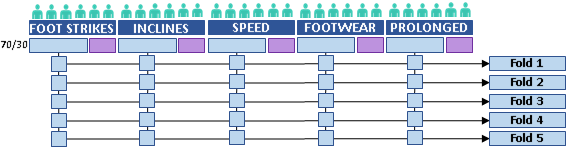

# Presettings

## Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Make imports

In [ ]:
import os
import math
import random
import numpy as np
import pickle

## Directories

In [ ]:
datadir = '/content/drive/My Drive/StepDetectionStudy/Data'
origdatasetsdir = datadir + '/OriginalDatasets'

# Helper functions (HF)

## SplitData

Splits a dictionary (DataDic) in two (set 1 and set 2) assuming each key in DataDic contains a list. The keys of interest can be passed as input to the function, otherwise it performs the splitting to every key.

There are two options to perform the splitting (SplitOption): using a pctege of the number of elements in the first layer of the list (SplitPctge, default is 30) or passing the indices of the elements in the list that should go to set 2 (Set2Idcs, default is None).

In [ ]:
def SplitData(DataDic, *Keys, **SplitOption):
    
# Parse optional inputs
  SplitPctge = SplitOption.get('SplitPctge', 30)
  Set2Idcs = SplitOption.get('Indices',None)

# if a subset of DataDic keys are not specified, include all keys
  if not Keys:
    Keys = DataDic.keys()

# Prealocate output dictionaries
  set1 = {}
  set2 = {}

# Find indices for smaller set (set 2)
  if Set2Idcs is None:
    set2_n = math.floor(len(DataDic[list(Keys)[0]])*SplitPctge/100) # SplitPctge to number
    Set2Idcs = random.sample(range(len(DataDic[list(Keys)[0]])),set2_n) # generate random idcs within the number of items in X

# Prealocate vars
  for key in Keys:
    set1[key] = []
    set2[key] = []
    
    for pti,pt in enumerate(DataDic[key]): # for each item in X
    
        if pti not in Set2Idcs: # if the index pti is not in set2, 
 
            set1[key].append(pt)

        else: 
        # go to set2
            set2[key].append(pt)
            
  return set1, set2

## KFoldCreator

Splits a dictionary (DataDic) in k folds of approximately equal number of elements and returns it as another dictionary where the keys are each fold. The keys of interest can be passed as input to the function, otherwise it performs the splitting to every key.


In [ ]:
def KFoldCreator(DataDic, k, *Keys):

# Parse optional input

  if not Keys: # get dictionary keys if none are specified
    Keys = DataDic.keys()

# Prealocate final output dictionary and create its keys
  foldedset = {}
  foldkeys = []
  for i in range(k):
    foldkeys.append("Fold_" + str(i))

# Create folds of indices for participants
  idcs = np.linspace(0,len(DataDic[list(Keys)[0]])-1,len(DataDic[list(Keys)[0]]),dtype=int) # indices
  random.shuffle(idcs) # shuffle them
  
  idxfolds = []
  foldmembern = len(idcs) / float(k) # ideal partition
  last = 0.0

  while last < len(idcs): # while last is smaller than max number of participants
    idxfolds.append(idcs[int(last):int(last + foldmembern)]) # append a fold of length close to ideal partition
    last += foldmembern # add the number of participants that have been added

# Allocate data within each fold
  for foldi, foldkey in enumerate(foldkeys): # for each fold
    datafold = {}
    for key in Keys: # for each variable
      datafold[key] = []
      for idx in idxfolds[foldi]: # for each index in the fold
        datafold[key].append(DataDic[key][idx]) # select the data corresponding to that index and append it

    foldedset[foldkey] = datafold # place it in the fold dictionary

  return foldedset


## FlattenDataset

Unnests a nested list of two levels. In this case, each dataset is a list (DatasetList), where the first sublevel is each participant and the next sublevel contains the trials performed by a given participant.

For instance, DatasetList[0][0] will access the all the strides of trial 1 for participant 1.

In [ ]:
def FlattenDataset(DatasetList):
    FlatList = []
    for participant in DatasetList:
        for trial in participant:
                FlatList = FlatList + trial
                
    return FlatList

# Main

### Load data

In [ ]:
data = {}

data['FootStrikes'] = np.load(origdatasetsdir + '/FootStrikes_dataset.npy', allow_pickle=True)
data['Speed'] = np.load(origdatasetsdir + '/Speed_dataset.npy', allow_pickle=True)
data['Footwear'] = np.load(origdatasetsdir + '/Footwear_dataset.npy', allow_pickle=True)
data['Prolonged'] = np.load(origdatasetsdir + '/Prolonged_dataset.npy', allow_pickle=True)
data['Inclines'] = np.load(origdatasetsdir + '/Inclines_dataset.npy', allow_pickle=True)

# Print out the participants and strides within each dataset
for seti in data.keys():
  data[seti] = data[seti].item()
  print(seti)
  print('    Participants: ' + str(len(data[seti]['X'])))
  print('    Strides: ' + str(len(FlattenDataset(data[seti]['X']))))
  print(' ')


FootStrikes
Participants: 28
Strides: 7222
 
Speed
Participants: 15
Strides: 4661
 
Footwear
Participants: 11
Strides: 3333
 
Prolonged
Participants: 16
Strides: 10622
 
Inclines
Participants: 10
Strides: 7866
 


### Split traing and testing sets

In [ ]:
train = {}
test = {}

for seti in list(data.keys()):
  train[seti], test[seti] = SplitData(data[seti], SplitPctge=30)
  print(seti + ' participants split (Training/Testing): ' + str(len(train[seti]['X'])) +'/' + str(len(test[seti]['X'])))


FootStrikes split (Training/Testing): 20/8
Speed split (Training/Testing): 11/4
Footwear split (Training/Testing): 8/3
Prolonged split (Training/Testing): 12/4
Inclines split (Training/Testing): 7/3


### 5-fold the training data

In [ ]:
folded = {}
kfolds = 5

for seti in list(train.keys()):
  folded[seti] = KFoldCreator(train[seti], 5)


### Save data to files

In [ ]:
trainingfolds = {}
testfinal = {}

# for each training fold
for fold in list(folded['FootStrikes'].keys()):
  trainingfolds[fold] = {}

  # horizontally concatenate each fold by variable
  for key in list(folded['FootStrikes'][fold].keys()):
    trainingfolds[fold][key] = folded['FootStrikes'][fold][key] + \
                               folded['Speed'][fold][key] + \
                               folded['Footwear'][fold][key] + \
                               folded['Prolonged'][fold][key] + \
                               folded['Inclines'][fold][key]

# concatenate datasets by variable in the testing set
for key in list(test['FootStrikes'].keys()):
    testfinal[key] = test['FootStrikes'][key] + \
                     test['Speed'][key] + \
                     test['Footwear'][key] + \
                     test['Prolonged'][key] + \
                     test['Inclines'][key]

np.save(datadir + '/DataFolds.npy', trainingfolds)
np.save(datadir + '/TestingSet.npy', testfinal)

## Print out fold counts

In [ ]:
ptn = []
stridesn = []
for fold in list(trainingfolds.keys()):
  ptn.append(len(trainingfolds[fold]['X']))
  stridesn.append(len(FlattenDataset(trainingfolds[fold]['X'])))

print('TRAINING DATA')
print('------------------')
print('Participants in each fold')
print(ptn)
print(' ')
print('Strides in each fold')
print(stridesn)
print('Mean: ' + str(np.mean(stridesn)))
print('Std: ' + str(np.std(stridesn)))

print(' ')
print('TESTING DATA')
print('------------------')
print('Participants')
print(len(testfinal['X']))
print(' ')
print('Strides')
print(len(FlattenDataset(testfinal['X'])))


TRAINING DATA
------------------
Participants in each fold
[10, 11, 12, 11, 14]
 
Strides in each fold
[3743, 4608, 5486, 4347, 6119]
Mean: 4860.6
Std: 842.7712856997443
 
TESTING DATA
------------------
Participants
22
 
Strides
9401
